# Stan model, constrained on the betas, allow for varying sigmas.

# Last updated 30.5.2018

### Notes

Changed 30.5

- Try no meta-terms. See how that works. 

Changed 28.5

- Slight change in the higher level metas - only use for the mu_m terms

Changed 25.5

- I want to go with what is hopefully a final specification:
- I want to use normal priors but with varying sigmas
- Get rid of higher level meta distributions for the mu in order to simplify the model. 
- Changed many fo the mu terms to Cauchy(0,1) to get a bit of regularization
- Go back to pooled meta-paramaters

Changed 23.5

- IN this version, I again allow for sigmas to vary
- Change back betas to be normal (0,1)

In this ver

Changed 22.5
 - Change back to fixed sd for b parameters, but now cauchy?

Changed 21.5 v2: 
 - Changed all the b priors to cauchy rather than normal
 - Also allowed sigmas to vary
 
Changed 21.5

- allowed b sigmas to vary
- Perhaps instead I should just try a weaker prior for the b. Use a cauchy instead, allow for less regularization?

Changed 20.5

- Added county effects to production level data: interact with month of year. 
- Every mu term now has its own higher level cauchy distribution. 

Changed 18.5

- Got rid of meta_mu, meta_sigma
- mu paramaters get Cauchy(0,2.5) priors
- Added total months production as variable. 

Changed 16.5

- Get some weird results with changes below, looks like one big outlier

- a and b changed to normal priors

- deleted a system that I deleted in the lmel model ("chaori"


Changed 14.5

- See if I can make bs to be stochastic

- Change transformation so that it is only descaled and not log-transformed. 

- standardize by dividing by 1 standard deviation and not 2, for ease of interpretation

### Preamble

In [1]:
!pip3 install --upgrade pip

  Using cached https://files.pythonhosted.org/packages/0f/74/ecd13431bcc456ed390b44c8a6e917c1820365cbebcb6a8974d1cd045ab4/pip-10.0.1-py2.py3-none-any.whl
  Found existing installation: pip 9.0.3
    Uninstalling pip-9.0.3:
      Successfully uninstalled pip-9.0.3


In [1]:
!pip3 install pystan

  Using cached https://files.pythonhosted.org/packages/96/62/1b9e1d0a4ce73f1f649c2d1370c1bc33a4933c127716490528ca3bfc043d/pystan-2.17.1.0-cp35-cp35m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/e9/87/d1880619f40f7ae1ec33ab6e798c74726b67dea287698efa6a1154d41701/Cython-0.28.3-cp35-cp35m-manylinux1_x86_64.whl
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
#import statsmodels.formula.api as smf
#import statsmodels.api as sm
import sys
import pystan
import scipy
import math
import re
import patsy
import collections as cl
import matplotlib as mpl
import pickle


pd.options.display.max_rows = 2000
pd.options.display.max_columns = 100


In [3]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.facecolor'] ="white"
plt.rcParams['grid.color'] ="grey"
plt.rcParams['grid.linestyle'] = "dotted"
plt.rcParams["axes.labelsize"]= 14
#plt.rcParams['figure.savefig.dpi'] = 100
plt.rcParams['savefig.edgecolor'] = "#f2f2f2"
plt.rcParams['savefig.facecolor'] ="white"
plt.rcParams["figure.figsize"] = [15,8]
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['font.size'] = 14
greens = ['#66c2a4','#41ae76','#238b45','#006d2c','#00441b']
multi =['#66c2a4','#1f78b4','#a6cee3','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']


In [4]:
import google.datalab.storage as storage
#get bucket names
from google.datalab import Context
import random, string
from io import BytesIO

### Functions

In [5]:
def get_percentiles(ser):
    return(np.percentile(ser, [2.5,15,50,85,97.5]))



In [6]:
def logit_to_prob(value):
    return(math.exp(value)/(1+math.exp(value)))



In [7]:
def load_data():
    %gcs read --object "gs://solar_commodities/prod_csi.csv" --variable solar_bytes

    solar_data = pd.read_csv(BytesIO(solar_bytes))
    return(solar_data)



In [8]:
def format_data(solar_data):
    solar_data = solar_data[solar_data.prod_kwh.notnull()]
    solar_data = solar_data[solar_data.months_operation.notnull()]
    solar_data = solar_data[solar_data.module_manufacturer!="Chaori"]
    #limit to data over three years
    print("done")
    solar_data = solar_data[solar_data.total_months_operation>=36]
    solar_data.loc[:,"month"] = solar_data.month.apply(lambda x: str(x))
    return(solar_data)

In [9]:
def transform_log(solar_data):
    solar_data.loc[:,"log_prod_kwh"] = np.log(solar_data.prod_kwh+ 0.00001)
    solar_data.loc[:,"log_cost_per_kw"] = np.log(solar_data.cost_per_kw + 0.00001)
    solar_data.loc[:,"log_csi_rating"] = np.log(solar_data.csi_rating + 0.00001)
    return(solar_data)



In [10]:

def create_num_dict(sseries):
    skeys  = sseries.unique()
    #numbered from 1 to N
    svalues=[i + 1 for i in range(0,len(skeys))]
    #create dict with both
    sys_dict = dict(zip(skeys, svalues))
    return(sys_dict)



In [11]:

def create_stan_data(solar_data):
    """
    Takes in dataframe and returns dict of stan data
    """
    #Observation level data (size N)
    #age of panel system in data
    N = solar_data.count(axis=0)[0]
    app_num = solar_data["app_num"]
    prod_kwh = solar_data["prod_kwh"]
    months_operation = solar_data["months_operation"]
    
    #month-county indicator
     #customer county effects
    county_dict = create_num_dict(solar_data["cust_county"])
    with open('county_dict.pkl', 'wb') as f:
      pickle.dump(county_dict, f)
    county_id = solar_data["cust_county"].map(county_dict)
    C = county_id.unique().size 
    month = solar_data["month"]
    
    solar_data["county_month"] = solar_data["month"] + solar_data["cust_county"]
    county_month_dict = create_num_dict(solar_data["county_month"])
    county_month_id = solar_data["county_month"].map(county_month_dict)
    CM = county_month_id.unique().size
    

    #create system_id from 1 to J for N data points
    sys_dict = create_num_dict(solar_data["app_num"])
    #save dict
    with open('sys_dict.pkl', 'wb') as f:
      pickle.dump(sys_dict, f)
    
    system_id =app_num.map(sys_dict)


    system_level_vars = ["app_num", "host_sector", "owner_sector", "csi_rating", "third_party_owned","module_manufacturer", "first_prod_year", "incentive_step", "cost_per_kw", "cust_county", 'total_months_operation']
    system_level_df = solar_data[system_level_vars][~solar_data.app_num.duplicated()]

    system_level_df["owner_sector"].value_counts()
    system_level_df["host_sector"].value_counts()

    unique_system_id = system_level_df["app_num"].map(sys_dict)
    J = unique_system_id.size

    #continuous variables at system level
    csi_rating = system_level_df["csi_rating"]
    cost_per_kw = system_level_df["cost_per_kw"]
    first_prod_year = system_level_df["first_prod_year"]
    incentive_step = system_level_df["incentive_step"]
    total_months_operation = system_level_df["total_months_operation"]

    #solar_data["incentive_step"].unique()

    #module_manufacturer data
    module_dict = create_num_dict(system_level_df["module_manufacturer"])
    module_id = system_level_df["module_manufacturer"].map(module_dict)
    M = module_id.unique().size
    with open('module_dict.pkl', 'wb') as f:
      pickle.dump(module_dict, f)

    #sector categories
    owner_sect_dict = create_num_dict(system_level_df["owner_sector"])
    with open('owner_sect_dict.pkl', 'wb') as f:
      pickle.dump(owner_sect_dict, f)
    #for varying effects
    owner_sect_id = system_level_df["owner_sector"].map(owner_sect_dict)
    
    #for dummy variables
    owner_sect_dummies = pd.get_dummies(system_level_df.owner_sector)
    S=4

    #lease variables
    L = 2
    lease_dict = create_num_dict(system_level_df["third_party_owned"])
    leased = system_level_df["third_party_owned"].map(lease_dict)

    solar_stan_data={
    "N":N, #observations
    "J":J, #systems
    "M":M, #module Manufacturers
    "L":L, #leased or not
    "S":S, #sector
    #"C":C, #number of counties
    "CM":CM, #number of county-months
    #observation data
    "system_id":system_id,
    "prod_kwh": prod_kwh,
    "months_operation": months_operation,
    #"month": month,
    #"county_id": county_id,
    "county_month_id": county_month_id,

    #system level data,
    "total_months_operation":total_months_operation,
    "cost_per_kw":cost_per_kw,
    "csi_rating": csi_rating,
    "first_prod_year": first_prod_year,
    #"incentive_step": incentive_step,
    "module_id": module_id,
    "owner_sect_id": owner_sect_id,
    "leased":leased
    }
    return(solar_stan_data)





In [12]:
def solar_stan_model():
    solar_stan_model = """
    data{
    	int<lower = 0> N; //number of observations
    	int<lower = 0> J; //number of groups
        int<lower = 0> M; //number of manufacturers
    	int<lower = 0> L; //lease/not lease =2
        int<lower=0> S; //Number of sectors
        //int<lower=0> C; //Number of counties
        int<lower=0> CM; //number of county-months

        //Observation Data
    	int system_id[N]; //Which of J installations does it belong too
    	vector[N] prod_kwh; //response variable
    	vector[N] months_operation; //main predictor
    	//int month[N]; // which of 12 months does it belong too.
        //int county_id[N];
        int county_month_id[N];
        
    	int leased[J]; //indicator variable for lease
        vector[J] total_months_operation; //total months of operation (min 35 max 60)
        vector[J] cost_per_kw; //cost per kw log
        vector[J] csi_rating; //size of system
        vector[J] first_prod_year; //year of first operation
        //vector[J] incentive_step;

        int module_id[J];
        int owner_sect_id[J];
    }

    transformed data{
        vector[N] st_prod_kwh;
        vector[N] st_months_operation;
        vector[J] st_cost_per_kw;
        vector[J] st_csi_rating;
        //vector[J] st_incentive_step;
        vector[J] st_first_prod_year;
        vector[J] st_total_months_operation;

        st_prod_kwh = (prod_kwh - mean(prod_kwh))/(sd(prod_kwh));

        st_months_operation = (months_operation - mean(months_operation))/(sd(months_operation));

        st_csi_rating = (csi_rating - mean(csi_rating))/(sd(csi_rating));

        //st_incentive_step = (incentive_step - mean(incentive_step))/(sd(incentive_step));

        st_first_prod_year = (first_prod_year - mean(first_prod_year))/(sd(first_prod_year));

        st_cost_per_kw = (cost_per_kw-mean(cost_per_kw))/(sd(cost_per_kw));

        st_total_months_operation = (total_months_operation-mean(total_months_operation))/(sd(total_months_operation));

    }

    parameters{
        real mu_cm;
        //real meta_mu;
        //real meta_m;
        //real meta_s;
        //real meta_cost;
        real mu_b0;
        real sigma_b1_mu;
        
        real<lower=0> sigma_b1_sigma;
        real<lower=0> sigma_b0;
        real<lower=0> sigma_b1[J];
        //real<lower=0> sigma_beta;
        real<lower=0> sigma;
        
        real<lower=0> sigma_cm;
        //real<lower=0> sigma_mu;
        //real<lower=0> sigma_m;
        //real<lower=0> sigma_s;
        //real<lower=0> sigma_cost;

        real b0[J];
        real<upper=0> b1[J];

        //real mu_mon[12];
        real cm[CM];
        
        real mu1_lease[L];
        real mu1_m[M];
        real mu1_s[S];
        //real mu1_c[C];

        real beta1_cost[L];

        real beta1_size;
        real beta1_fy;
        real beta1_tmo;
    }

    transformed parameters {
        real mu_b1[J];
    	real y_hat[N]; //individual means

        for (j in 1:J){
    		mu_b1[j]=mu1_lease[leased[j]] + 
            mu1_s[owner_sect_id[j]]  +
            mu1_m[module_id[j]]+
            beta1_fy*st_first_prod_year[j] +
            beta1_size*st_csi_rating[j] +
            beta1_cost[leased[j]]*st_cost_per_kw[j] +
            beta1_tmo*st_total_months_operation[j];
            }

    	for (i in 1:N){
    		y_hat[i] = b0[system_id[i]] + b1[system_id[i]]*st_months_operation[i] + cm[county_month_id[i]];
    	}
    }

    model{
        mu_b0 ~ cauchy(0,2.5);
        sigma_b0 ~ cauchy(0,5);
        
        mu_cm ~ cauchy(0, 2.5);
        //meta_l ~ cauchy(0, 2.5);
        //meta_m ~ cauchy(0, 2.5);
        //meta_s ~ cauchy(0, 2.5);
        //meta_cost ~ cauchy(0, 2.5);
        
        sigma_b1_mu ~ cauchy(0,2.5);
        
        sigma ~ cauchy(0,5);
        sigma_cm ~ cauchy(0, 5);
        //sigma_l ~ cauchy(0, 5);
        //sigma_m~ cauchy(0, 5);
        //sigma_s~ cauchy(0, 5);
        //sigma_cost~ cauchy(0, 5);
        sigma_b1_sigma ~ cauchy(0,5);
        
        to_vector(sigma_b1) ~ cauchy(sigma_b1_mu, sigma_b1_sigma);

        to_vector(b0) ~ normal(mu_b0, sigma_b0);
        
        to_vector(b1) ~ normal(mu_b1, sigma_b1);
        
        to_vector(cm) ~ normal(mu_cm, sigma_cm);
        
        //meta_mu ~ cauchy(0,1);
        //sigma_mu ~ cauchy(0,5);
        
        to_vector(mu1_lease)~ cauchy(0, 1);
        
        to_vector(mu1_m)~ cauchy(0, 1);
        
        to_vector(mu1_s)~ cauchy(0, 1);
        
        to_vector(beta1_cost) ~ cauchy(0, 1);

        beta1_size~cauchy(0,1);
        beta1_fy~cauchy(0,1);
        
        beta1_tmo~cauchy(0,1);

    	st_prod_kwh ~ normal(y_hat, sigma);
    }
    """
    return(solar_stan_model)



In [13]:
solar_data = load_data()
print(solar_data.size)
solar_data = format_data(solar_data)
print(solar_data.size)

8254495
done
7354161


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


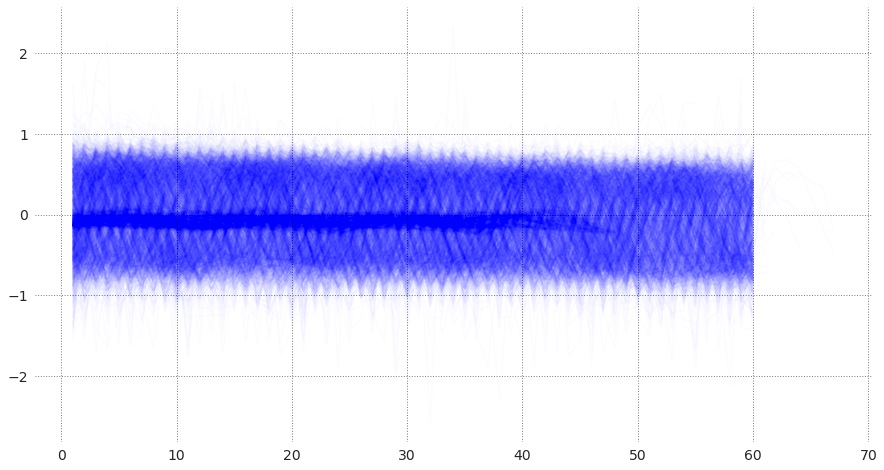

In [14]:
grouped_df = solar_data.groupby("app_num")
fig, ax = plt.subplots()
for df in grouped_df:
    ax.plot(df[1].months_operation, df[1].prod_scaled, color="blue", alpha=.01)
plt.show()

In [14]:

solar_stan_data = create_stan_data(solar_data);


In [15]:
stan_model_code = solar_stan_model()
solar_stan_model = pystan.StanModel(model_code=stan_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9e43f099f274f54a974da38ffc73fb85 NOW.


In [16]:

solar_stan_fit = solar_stan_model.sampling(data=solar_stan_data, iter=1000, chains=4)


/usr/local/envs/py3env/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [17]:
solar_extr = solar_stan_fit.extract(permuted=True)



In [18]:
with open('solar_extr_may18final2_const.pkl', 'wb') as f:
  pickle.dump(solar_extr, f)

#copy pickle item to google storage
!gsutil cp 'solar_extr_may18final2_const.pkl' gs://solar_commodities



Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update

Copying file://solar_extr_may18final2_const.pkl [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/ [1 files][  2.8 GiB/  2.8 GiB]   14.6 MiB/s                                   
Operation completed over 1 

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


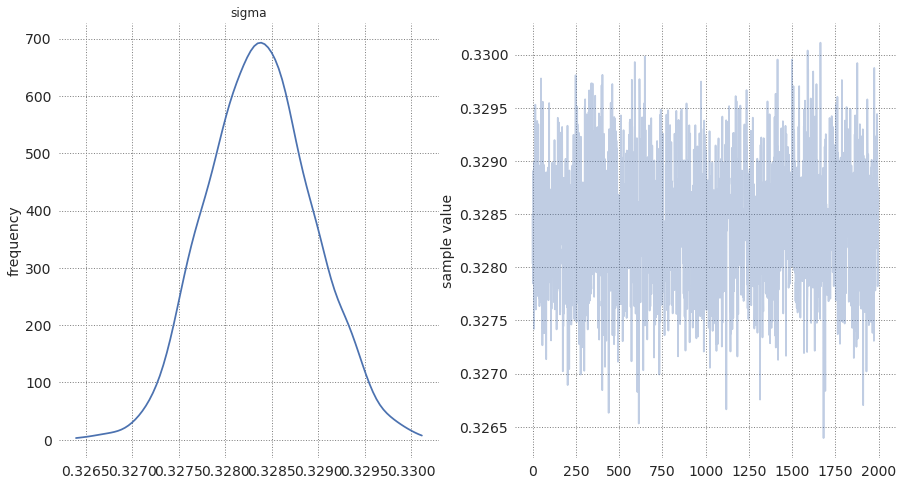

In [ ]:
sigma_trace = solar_stan_fit.plot("sigma")


In [ ]:
solar_stan_fit.plot("mu1_lease")

In [ ]:
print(solar_stan_fit)

test

In [ ]:
3+3

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
